In [1]:
import dsps
from dsps import load_ssp_templates
from dsps.cosmology import age_at_z, DEFAULT_COSMOLOGY
from dsps import calc_rest_sed_sfh_table_lognormal_mdf
from dsps import calc_rest_sed_sfh_table_met_table
import numpy as np
from matplotlib import pyplot as plt

from jax import grad
import jax.numpy as jnp
from jax import vmap 
from tqdm.autonotebook import tqdm
from astropy.constants import L_sun
import astropy.units as u
import numpy.ma as ma

/var/folders/gw/k3g4y13d0_38hyq_g18hp1s80000gn/T/ipykernel_55156/2811561078.py:12: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
# ! curl https://portal.nersc.gov/project/hacc/aphearin/DSPS_data/ssp_data_fsps_v3.2_lgmet_age.h5 > tempdata.h5

In [3]:
ssp_data = load_ssp_templates(fn='tempdata.h5')

print(ssp_data._fields)

print('\nssp_lgmet.shape = {}'.format(ssp_data.ssp_lgmet.shape))
print('ssp_lg_age_gyr.shape = {}'.format(ssp_data.ssp_lg_age_gyr.shape))
print('ssp_wave.shape = {}'.format(ssp_data.ssp_wave.shape))
print('ssp_flux.shape = {}'.format(ssp_data.ssp_flux.shape))

('ssp_lgmet', 'ssp_lg_age_gyr', 'ssp_wave', 'ssp_flux')

ssp_lgmet.shape = (12,)
ssp_lg_age_gyr.shape = (107,)
ssp_wave.shape = (5994,)
ssp_flux.shape = (12, 107, 5994)


In [4]:
gal_t_table = np.linspace(0.05, 13.8, 100) # age of the universe in Gyr
gal_sfr_table = np.random.uniform(0, 10, gal_t_table.size) # SFR in Msun/yr

gal_lgmet = -2.0 # log10(Z)
gal_lgmet_scatter = 0.2 # lognormal scatter in the metallicity distribution function

In [5]:
print(DEFAULT_COSMOLOGY)

z_obs = 0.5
t_obs = age_at_z(z_obs, *DEFAULT_COSMOLOGY) # age of the universe in Gyr at z_obs
t_obs = t_obs[0] # age_at_z function returns an array, but SED functions accept a float for this argument

CosmoParams(Om0=0.3075, w0=-1.0, wa=0.0, h=0.6774)


In [6]:
sed_info = calc_rest_sed_sfh_table_lognormal_mdf(
    gal_t_table, gal_sfr_table, gal_lgmet, gal_lgmet_scatter,
    ssp_data.ssp_lgmet, ssp_data.ssp_lg_age_gyr, ssp_data.ssp_flux, t_obs)

gal_lgmet_table = np.linspace(-3, -2, gal_t_table.size)

sed_info2 = calc_rest_sed_sfh_table_met_table(
    gal_t_table, gal_sfr_table, gal_lgmet_table, gal_lgmet_scatter,
    ssp_data.ssp_lgmet, ssp_data.ssp_lg_age_gyr, ssp_data.ssp_flux, t_obs)

In [7]:
def get_emission_line_flux():
    

_IncompleteInputError: incomplete input (669441264.py, line 2)

In [ ]:
continuum_fit_lo = 6480
continuum_fit_hi = 6650

halpha_line_lo = 6556
halpha_line_wave = 6562.8
halpha_line_hi = 6572

In [8]:
continuum_fit_lo, halpha_line_wave, continuum_fit_hi

NameError: name 'continuum_fit_lo' is not defined

In [9]:
sel = (ssp_data.ssp_wave>continuum_fit_lo) & (ssp_data.ssp_wave<continuum_fit_hi)
continuum_wave      = ssp_data.ssp_wave[sel]
continuum_flux_true = sed_info.rest_sed[sel]
continuum_rest_sed  = sed_info.rest_sed[sel]

NameError: name 'continuum_fit_lo' is not defined

In [10]:
len(continuum_rest_sed), len(continuum_wave), len(continuum_flux_true)

(188, 188, 188)

In [11]:
mask_lo, mask_hi = 6530, 6600
mask = (continuum_wave > mask_lo) & (continuum_wave < mask_hi)
continuum_wave_masked = ma.array(continuum_wave, mask = mask)
continuum_flux_true_masked = ma.array(continuum_flux_true, mask = mask)

In [12]:
def quad_continuum_model(theta, wave):
    c0 = theta["c0"]
    c1 = theta["c1"]
    c2 = theta["c2"]

    return (c2*wave*wave) + (c1*wave) + c0

In [13]:
def mse(flux_true: jnp.ndarray, flux_pred: jnp.ndarray) -> jnp.float64:
    """Mean squared error function."""
    return jnp.mean(jnp.power(flux_true - flux_pred, 2))

In [14]:
def mseloss(theta, model, wave, flux_true):
    flux_pred = model(theta, wave)
    return mse(flux_true, flux_pred)

In [15]:
dmseloss = grad(mseloss)

In [16]:
def model_optimization_loop(theta, model, loss, dloss, wave, flux_true, n_steps=10000, step_size=1e-18):
    
    losses = []

    for i in tqdm(range(n_steps)):
        
        grads = dloss(dict(c0=theta["c0"], c1=theta["c1"], c2=theta["c2"]), model, wave, flux_true)
        
        theta["c0"] = theta["c0"] - step_size*grads["c0"]
        theta["c1"] = theta["c1"] - step_size*grads["c1"]
        theta["c2"] = theta["c2"] - step_size*grads["c2"]

        losses.append(loss(dict(c0=theta["c0"], c1=theta["c1"], c2=theta["c2"]), model, wave, flux_true))

    return losses, theta

In [17]:
# c0_rand = 7e-5
# c1_rand = 1e-18
# c2_rand = -3e-18

c0_rand = np.mean(continuum_flux_true_masked)
c1_rand = 1e-18
c2_rand = -3e-18

In [18]:
c0_rand, c1_rand, c2_rand

(np.float64(5.400567733212274e-05), 1e-18, -3e-18)

In [19]:
model_flux_rand = quad_continuum_model(dict(c0=c0_rand, c1=c1_rand, c2=c2_rand), continuum_wave_masked.compressed())

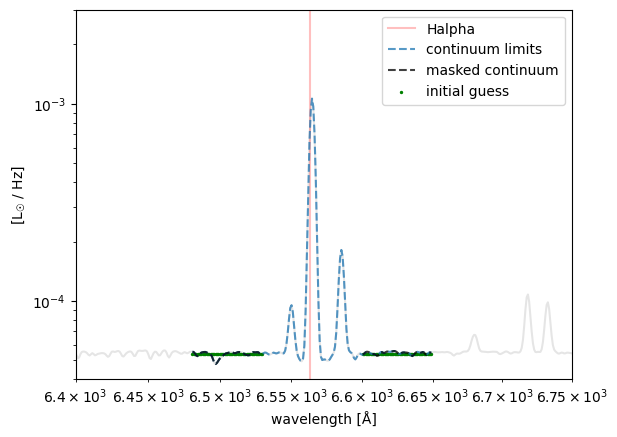

In [68]:
fig, ax = plt.subplots(1, 1)
__=ax.loglog()

__=ax.plot(ssp_data.ssp_wave, sed_info.rest_sed, alpha=0.1, c='k')
__=ax.axvline(halpha_line_wave, label='Halpha', alpha=0.25, c='r')

__=ax.plot(continuum_wave, continuum_flux_true, alpha=0.75, ls='--', label='continuum limits')

__=ax.plot(continuum_wave_masked, continuum_flux_true_masked, alpha=0.75, ls='--', c='k', label='masked continuum')

__=ax.scatter(continuum_wave_masked.compressed(), model_flux_rand, alpha=1, s=2, c='g', label='initial guess')

__=ax.set_xlim(6.4e3,6.75e3)
__=ax.set_ylim(4e-5,3e-3)
__=ax.set_xlabel('wavelength [\u212b]')
__=ax.set_ylabel('[L$_{\u2609}$ / Hz]')

plt.legend()
plt.show()

In [21]:
mseloss(dict(c0=c0_rand, c1=c1_rand, c2=c2_rand), quad_continuum_model, continuum_wave_masked.compressed(), continuum_flux_true_masked.compressed())


Array(2.05526802e-12, dtype=float64)

In [22]:
dmseloss(dict(c0=c0_rand, c1=c1_rand, c2=c2_rand), quad_continuum_model, continuum_wave_masked.compressed(), continuum_flux_true_masked.compressed())


{'c0': Array(-2.58602034e-10, dtype=float64),
 'c1': Array(-5.70063051e-05, dtype=float64, weak_type=True),
 'c2': Array(-0.73678815, dtype=float64, weak_type=True)}

In [23]:
losses, theta = model_optimization_loop(dict(c0=c0_rand, c1=c1_rand, c2=c2_rand),
                                             quad_continuum_model, mseloss, dmseloss, 
                                        continuum_wave_masked.compressed(), continuum_flux_true_masked.compressed())

  0%|          | 0/10000 [00:00<?, ?it/s]

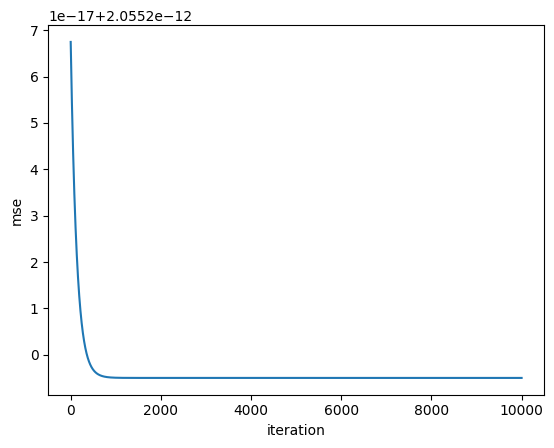

In [24]:
plt.plot(losses)
plt.xlabel('iteration')
plt.ylabel('mse')
plt.show()

In [25]:
theta

{'c0': Array(5.40056773e-05, dtype=float64),
 'c1': Array(4.78241421e-19, dtype=float64, weak_type=True),
 'c2': Array(1.95223299e-16, dtype=float64, weak_type=True)}

In [26]:
continuum_flux_fit = quad_continuum_model(dict(c0=theta["c0"], c1=theta["c1"], c2=theta["c2"]), continuum_wave_masked.compressed())

In [27]:
continuum_flux_fit_interp = np.interp(continuum_wave, continuum_wave_masked.compressed(), continuum_flux_fit)

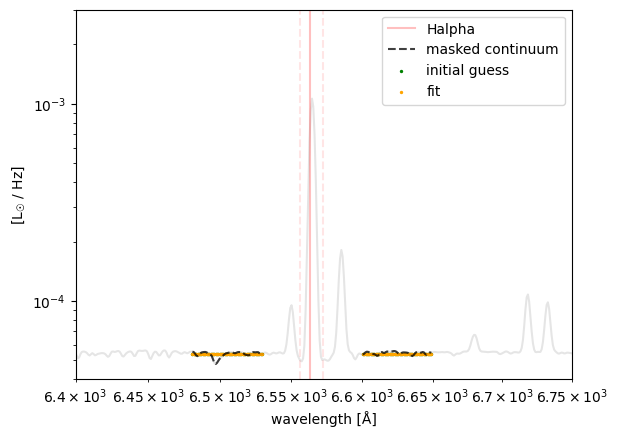

In [66]:
fig, ax = plt.subplots(1, 1)
__=ax.loglog()
__=ax.plot(ssp_data.ssp_wave, sed_info.rest_sed, alpha=0.1, c='k')


__=ax.axvline(halpha_line_lo, alpha=0.1, c='r', ls='--')
__=ax.axvline(halpha_line_wave, label='Halpha', alpha=0.25, c='r')
__=ax.axvline(halpha_line_hi, alpha=0.1, c='r', ls='--')




__=ax.plot(continuum_wave_masked, continuum_flux_true_masked, alpha=0.75, ls='--', c='k', label='masked continuum')

__=ax.scatter(continuum_wave_masked.compressed(), model_flux_rand, alpha=1, s=2, c='g', label='initial guess')


__=ax.scatter(continuum_wave_masked.compressed(), continuum_flux_fit, alpha=1, s=2, c='orange', label='fit')

#__=ax.scatter(continuum_wave, continuum_flux_fit_interp, alpha=1, s=0.1, c='r', label='fit (interpolated)')


__=ax.set_xlim(6.4e3,6.75e3)
__=ax.set_ylim(4e-5,3e-3)

__=ax.set_xlabel('wavelength [\u212b]')
__=ax.set_ylabel('[L$_{\u2609}$ / Hz]')

plt.legend()
plt.show()

In [53]:
line_sel = (continuum_wave >= halpha_line_lo) & (continuum_wave <= halpha_line_hi)

continuum_wave_line = continuum_wave[line_sel]
line_Lsol = continuum_rest_sed[line_sel] - continuum_flux_fit_interp[line_sel]
line_Lnu = line_Lsol * L_sun.cgs.value

In [69]:
L_sun.cgs.value

np.float64(3.828e+33)

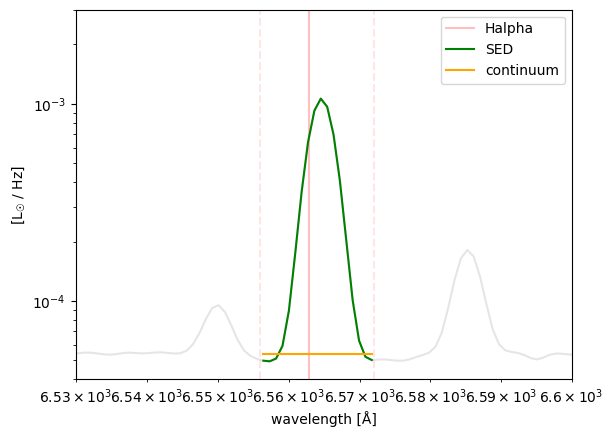

In [67]:
fig, ax = plt.subplots(1, 1)
__=ax.loglog()
__=ax.plot(ssp_data.ssp_wave, sed_info.rest_sed, alpha=0.1, c='k')


__=ax.axvline(halpha_line_lo, alpha=0.1, c='r', ls='--')
__=ax.axvline(halpha_line_wave, label='Halpha', alpha=0.25, c='r')
__=ax.axvline(halpha_line_hi, alpha=0.1, c='r', ls='--')

__=ax.plot(continuum_wave_line, continuum_rest_sed[line_sel], alpha=1, c='g', label='SED')
__=ax.plot(continuum_wave_line, continuum_flux_fit_interp[line_sel], alpha=1, c='orange', label='continuum')


__=ax.set_xlim(6.53e3,6.6e3)
__=ax.set_ylim(4e-5,3e-3)

__=ax.set_xlabel('wavelength [\u212b]')
__=ax.set_ylabel('[L$_{\u2609}$ / Hz]')

plt.legend()
plt.show()

In [61]:
continuum_wave_line_AA = continuum_wave_line * u.AA
continuum_freq_line_Hz = continuum_wave_line_AA.to(u.Hz, equivalencies=u.spectral()).value

In [62]:
continuum_freq_line_Hz

array([4.57250876e+14, 4.57188110e+14, 4.57125355e+14, 4.57062625e+14,
       4.56999869e+14, 4.56937173e+14, 4.56874494e+14, 4.56811825e+14,
       4.56749180e+14, 4.56686510e+14, 4.56623900e+14, 4.56561300e+14,
       4.56498724e+14, 4.56436165e+14, 4.56373581e+14, 4.56311056e+14,
       4.56248542e+14, 4.56186051e+14])

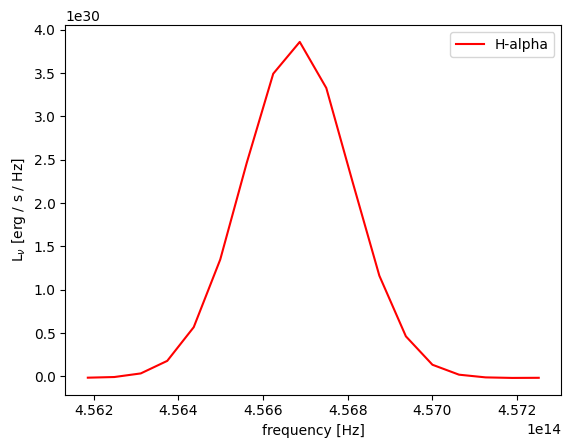

In [63]:
plt.plot(continuum_freq_line_Hz, line_Lnu, c='r', 
         label='H-alpha')

plt.xlabel('frequency [Hz]')
plt.ylabel('L$_{\u03bd}$ [erg / s / Hz]')
plt.legend()
plt.show()

In [64]:
line_L_cgs = np.trapezoid(line_Lnu, continuum_freq_line_Hz)

In [65]:
line_L_cgs

np.float64(-1.2045208713225068e+42)

In [76]:
d = 10 * u.pc
	

In [80]:
pwd


'/Users/kumail/github/diff_warmup'

In [79]:
d.to(u.cm).value

np.float64(3.085677581491367e+19)